In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
from sklearn.svm import SVR

import pickle
warnings.filterwarnings('ignore')

## Functions

In [11]:
def predict_evaluate(pred, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    resultingPlot = plt.figure(figsize=(25,10))
    plt.plot(true, color='red', label='Original Usage')
    plt.plot(prediction, color='blue', label='Predicted Usage')
    plt.plot(diff, color='green', label='Error')
    plt.title(graphName)
    plt.ylabel('kW')
    plt.legend()
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)[0]
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=24,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [12]:
directory = "../../datsets/LCL_Data_Transformed/"
allHouses = sorted(os.listdir(directory))

testNumber = 10

testUsers = sample(allHouses, testNumber)

featuresNames = ['use', 'hour', 'weekday', 'month']
targetName = ['use']
past_window = 24

## Test specific model SVM

Testing with  MAC003239.csv


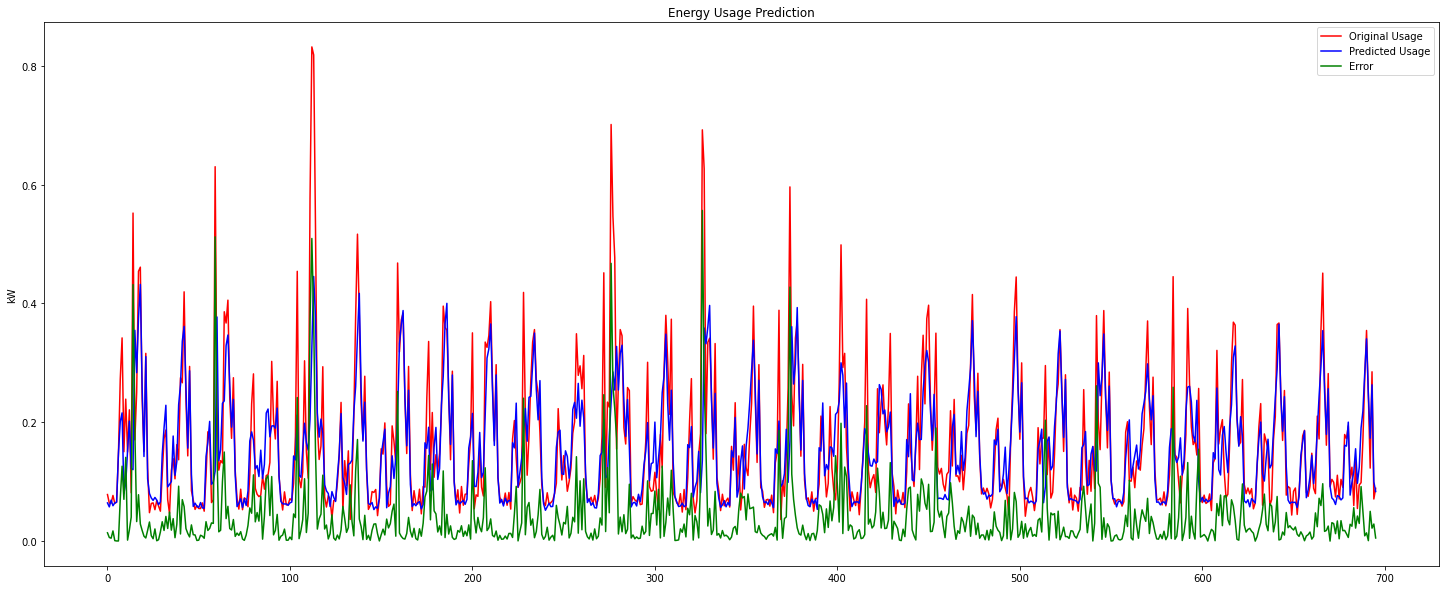

Mean Absolute Percentage Error:  0.2562200335425215
Mean Absolute Error:  0.04139111862135841
Max Absolute Error:  0.5564215526996559
Mean Squared Error:  0.005666546053683959
Testing with  MAC002026.csv


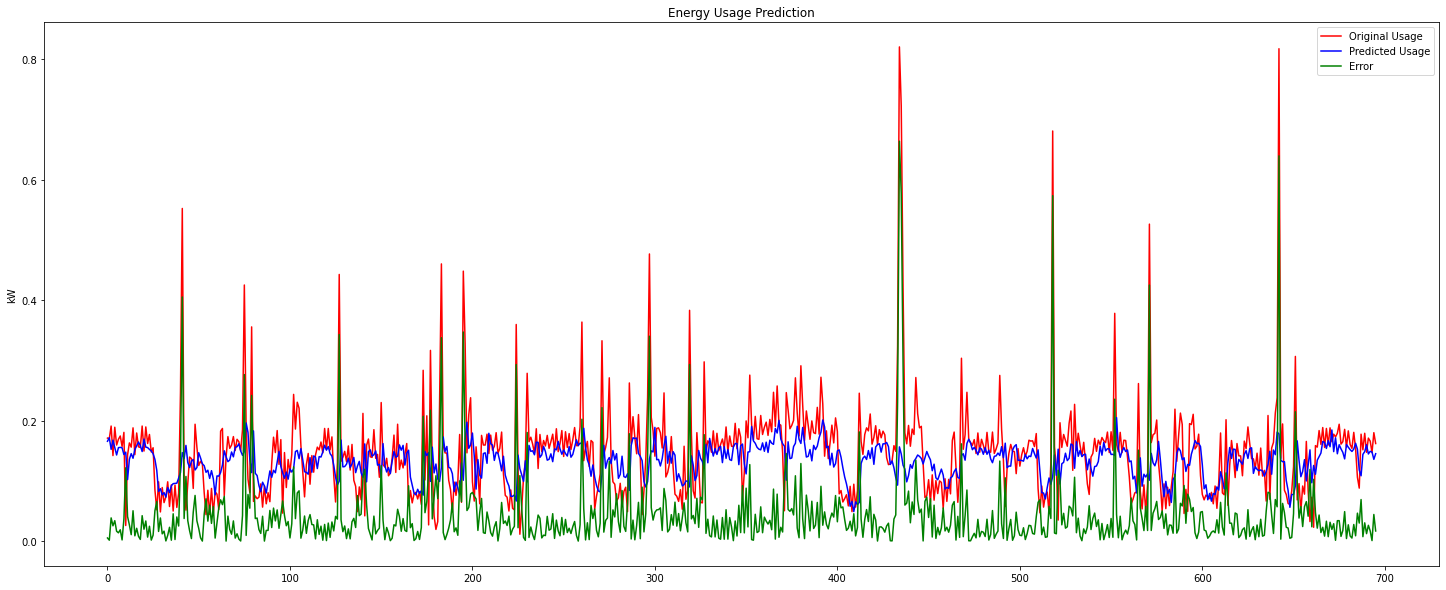

Mean Absolute Percentage Error:  0.3642003227861261
Mean Absolute Error:  0.0453020574437946
Max Absolute Error:  0.6635621631948124
Mean Squared Error:  0.0065642253405184025
Testing with  MAC001029.csv


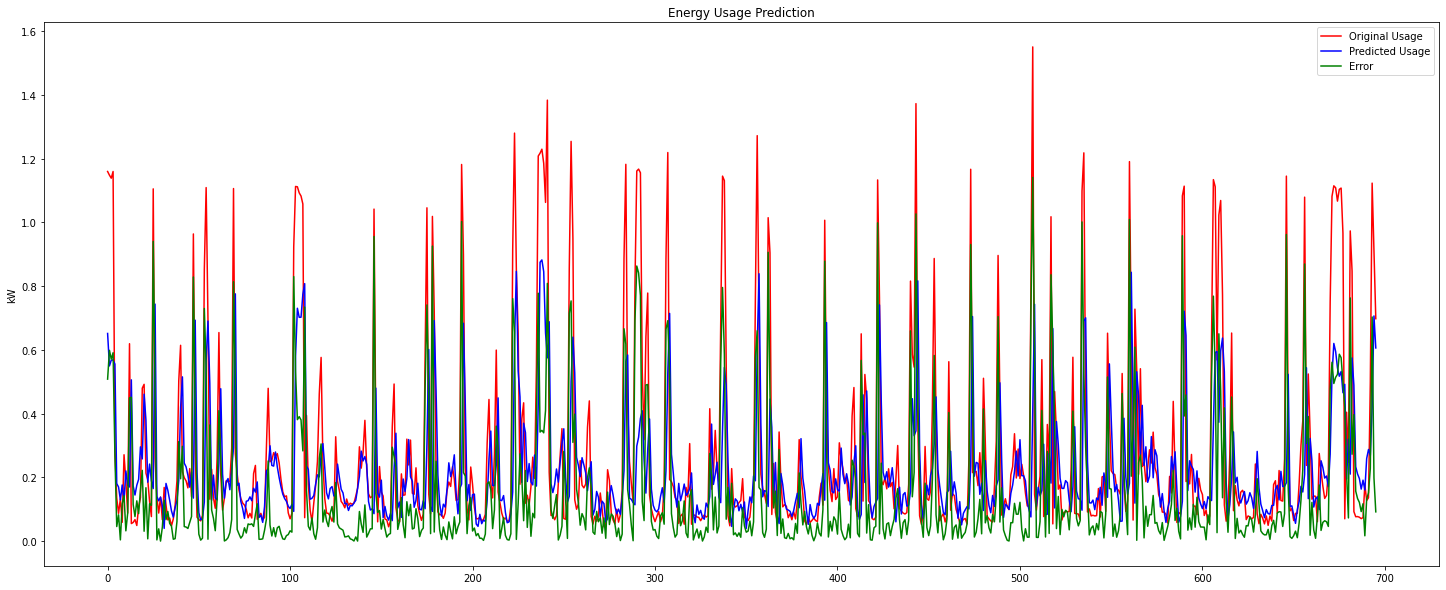

Mean Absolute Percentage Error:  0.6551056367535313
Mean Absolute Error:  0.16177505527137562
Max Absolute Error:  1.1415176745281785
Mean Squared Error:  0.0754722394888905
Testing with  MAC000201.csv


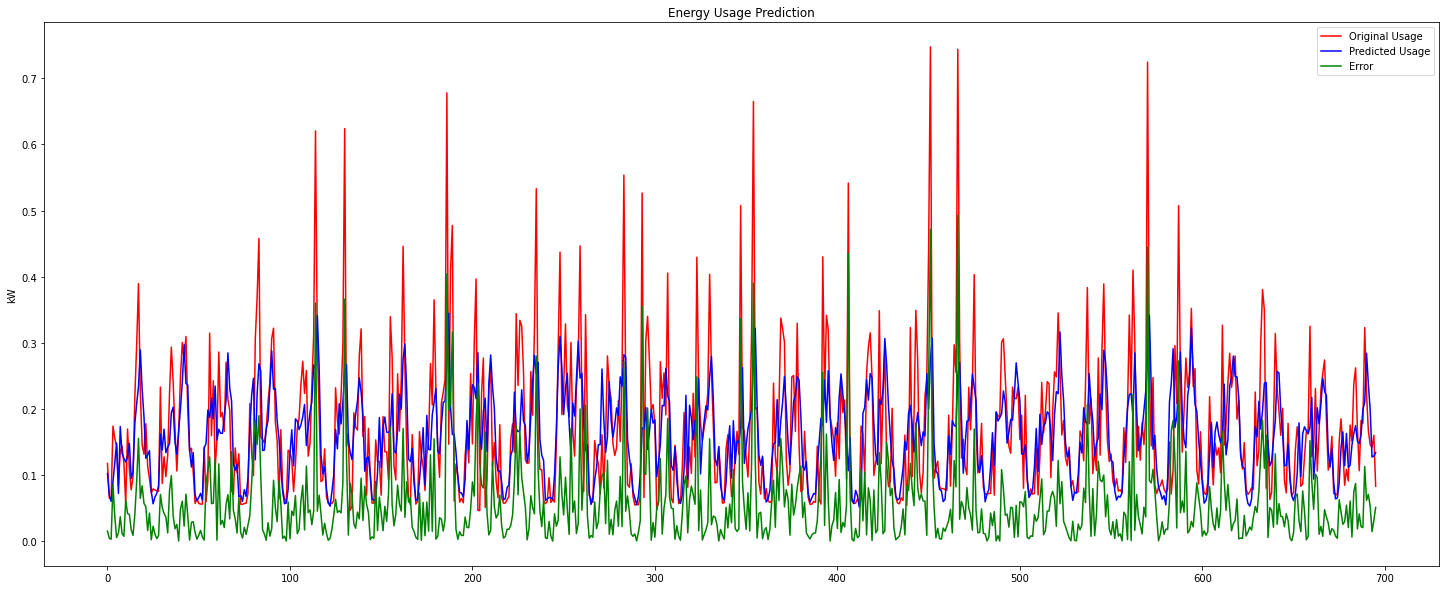

Mean Absolute Percentage Error:  0.3505517787739351
Mean Absolute Error:  0.056037981268117446
Max Absolute Error:  0.4928164252163961
Mean Squared Error:  0.007367614186339583
Testing with  MAC002172.csv


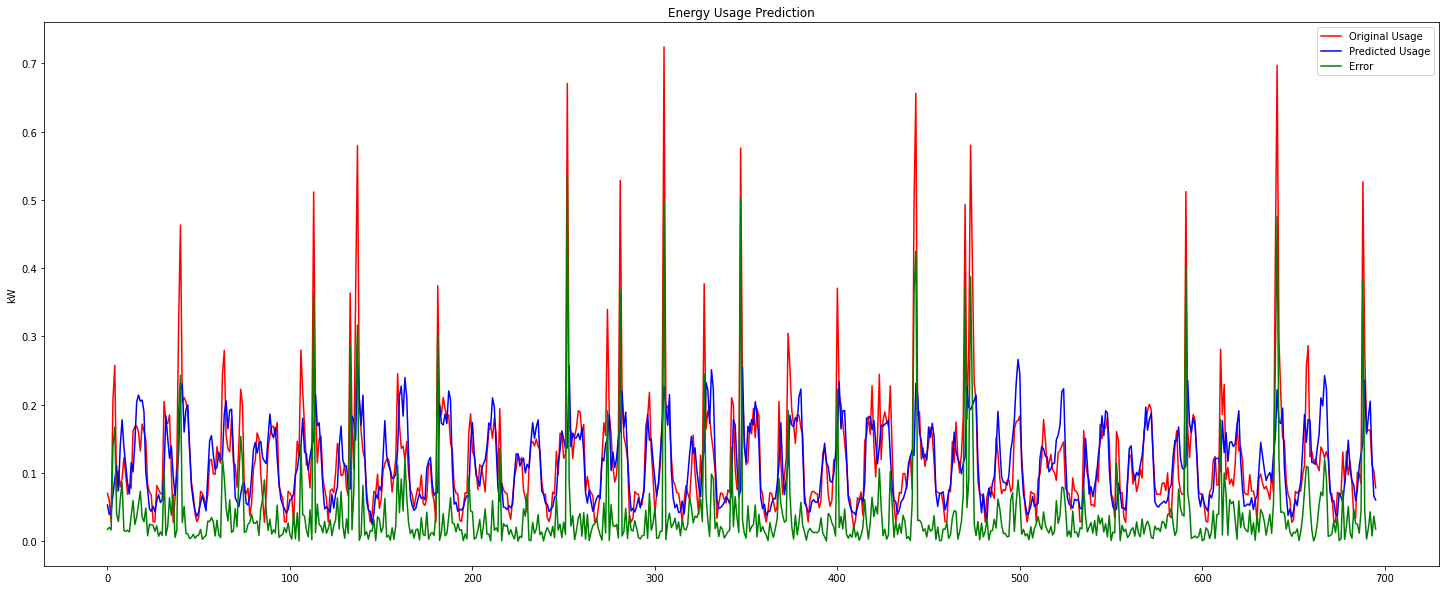

Mean Absolute Percentage Error:  0.3093402917244766
Mean Absolute Error:  0.0382420471222583
Max Absolute Error:  0.5340413299591265
Mean Squared Error:  0.005579148596499391
Testing with  MAC000054.csv


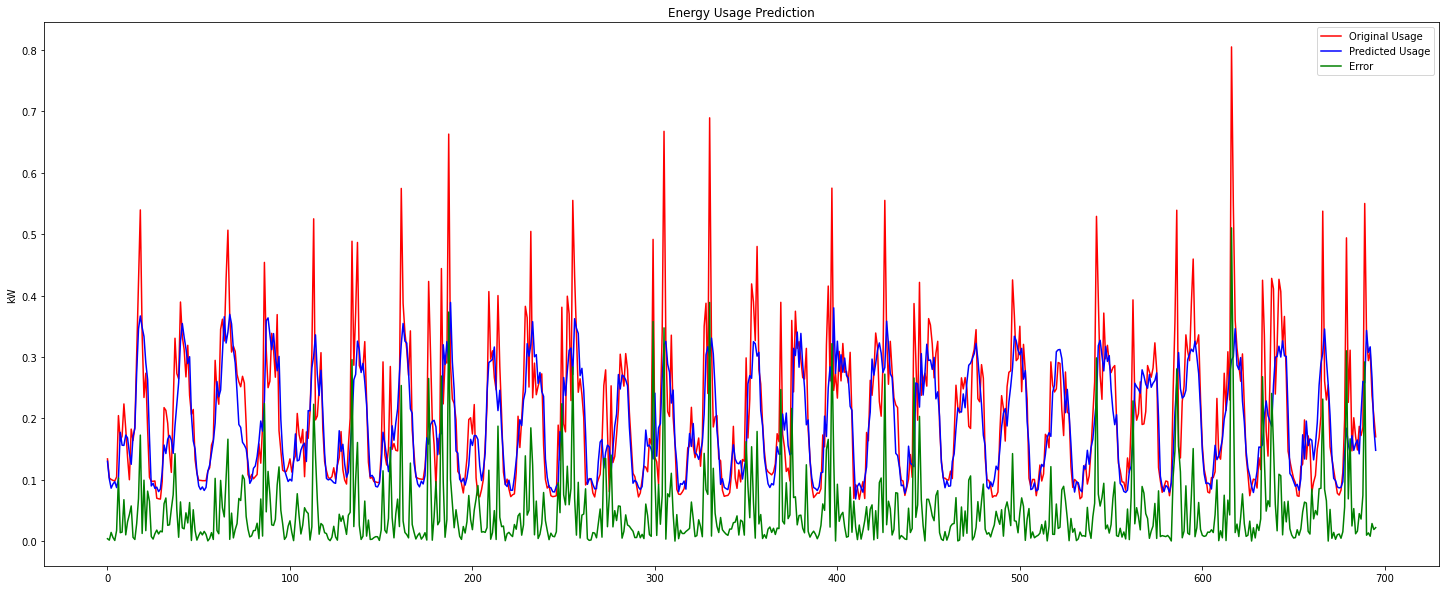

Mean Absolute Percentage Error:  0.21360835013208557
Mean Absolute Error:  0.0479248500806143
Max Absolute Error:  0.5102952220834511
Mean Squared Error:  0.006132749546642974
Testing with  MAC001668.csv


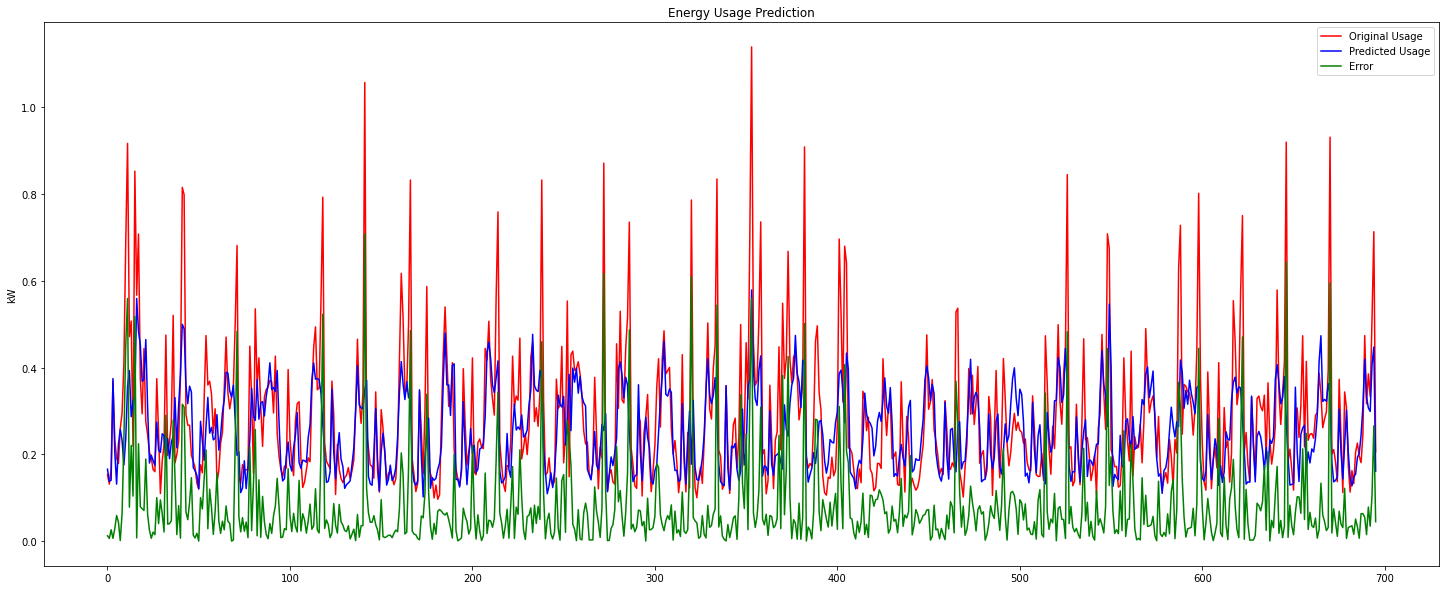

Mean Absolute Percentage Error:  0.25944132921045576
Mean Absolute Error:  0.08050916795381591
Max Absolute Error:  0.7086746566387121
Mean Squared Error:  0.017517245495239028
Testing with  MAC001971.csv


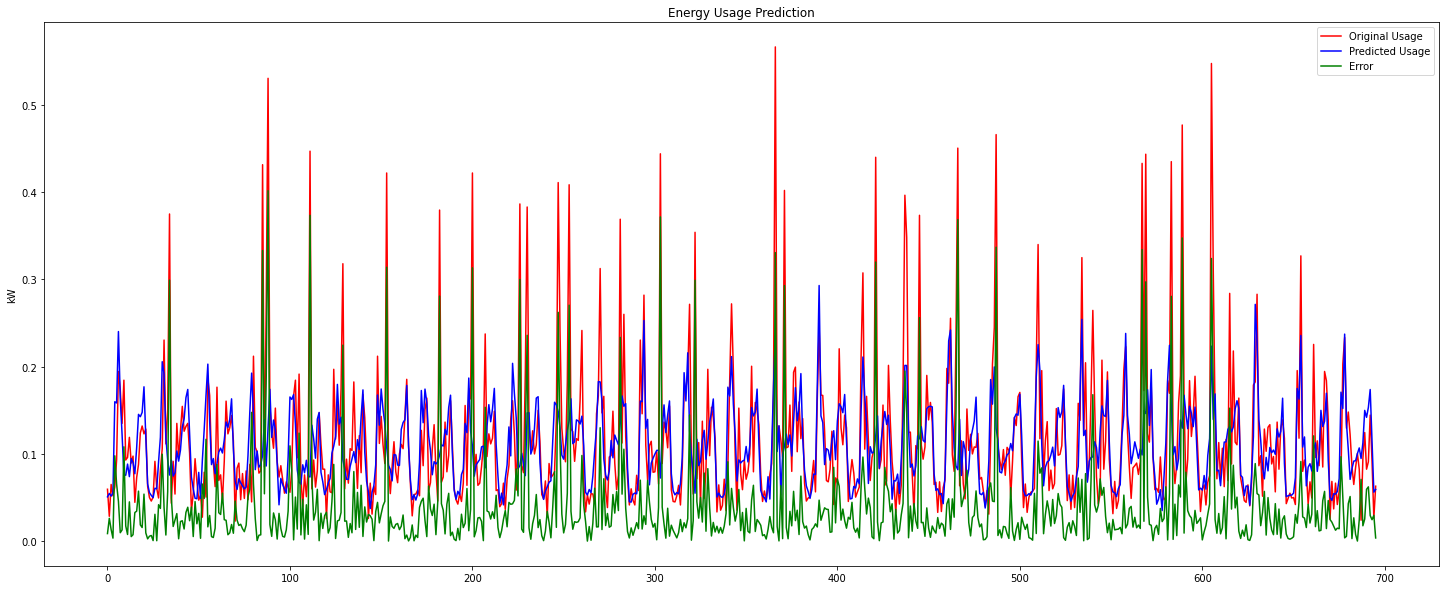

Mean Absolute Percentage Error:  0.3596496848061363
Mean Absolute Error:  0.04073236462456986
Max Absolute Error:  0.401675552889816
Mean Squared Error:  0.005290637502400113
Testing with  MAC002150.csv


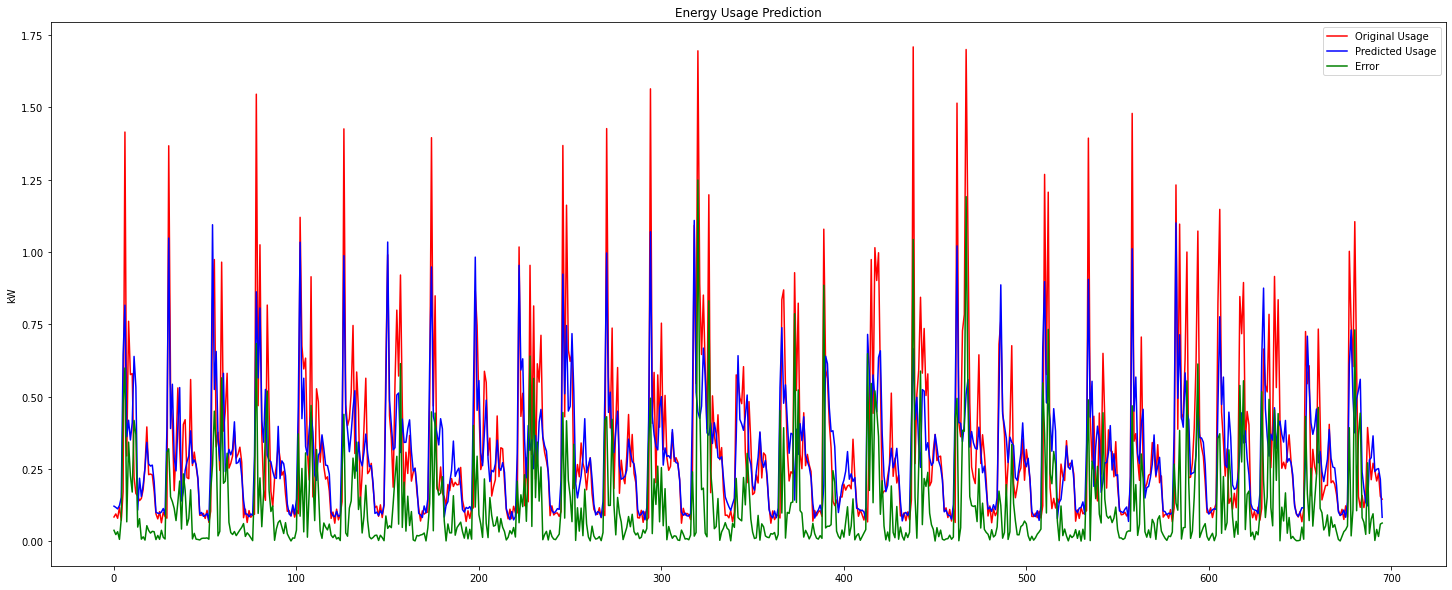

Mean Absolute Percentage Error:  0.4236274601888121
Mean Absolute Error:  0.11954314023866947
Max Absolute Error:  1.249066973036682
Mean Squared Error:  0.041206909368874944
Testing with  MAC000166.csv


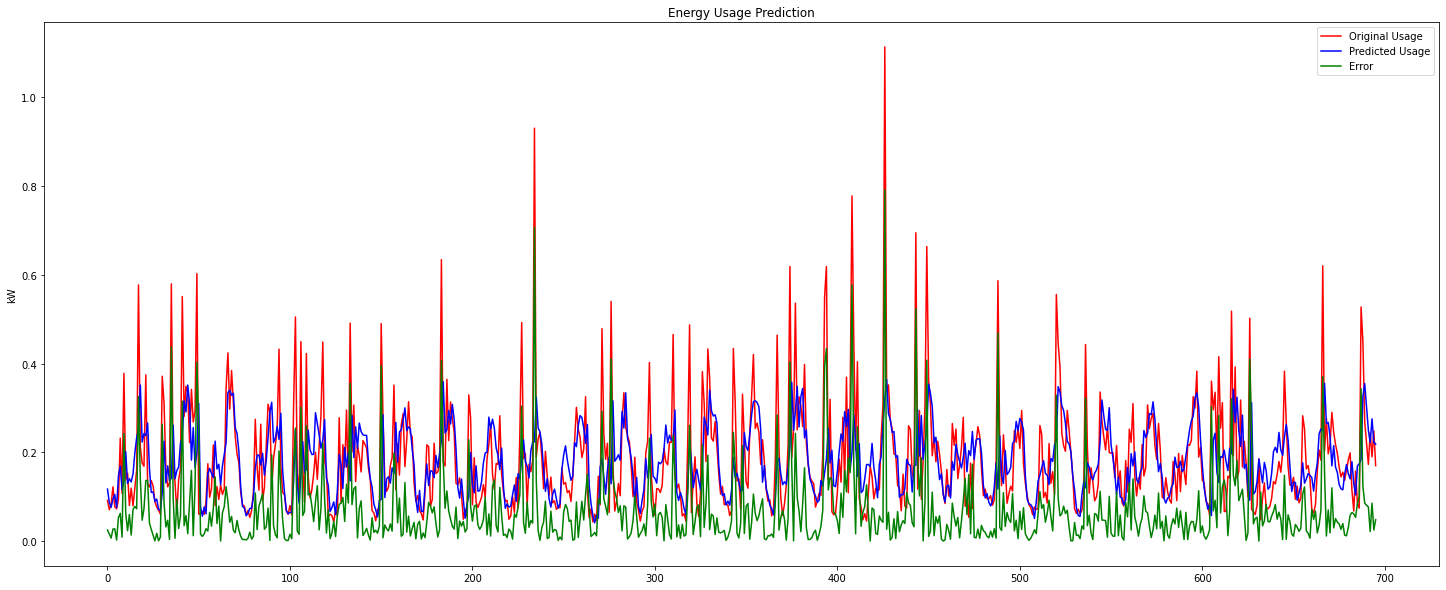

Mean Absolute Percentage Error:  0.4090567780313062
Mean Absolute Error:  0.07078340571024172
Max Absolute Error:  0.7916630198610553
Mean Squared Error:  0.012828186216057956


In [13]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')

    specific_model = SVR(kernel = "rbf")
        
    features = df[featuresNames].values
    target = df[targetName].values.reshape(-1, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=24*30, shuffle=False)


    #SCALE
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
    

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train)

    #Time series
    batch_size=1
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)
    svr_x_Train = [arr[0].flatten() for arr in train_generator]
    svr_y_Train = [arr[1].flatten() for arr in train_generator]
    svr_x_Test = [arr[0].flatten() for arr in test_generator]
    
    specific_model.fit(svr_x_Train, svr_y_Train)


    prediction = specific_model.predict(svr_x_Test).reshape(-1, 1)
    prediction = y_scaler.inverse_transform(prediction)
    predict_evaluate(prediction, y_test[past_window:], showplots=True)

## Test specific model LSTM

Testing with  MAC003239.csv


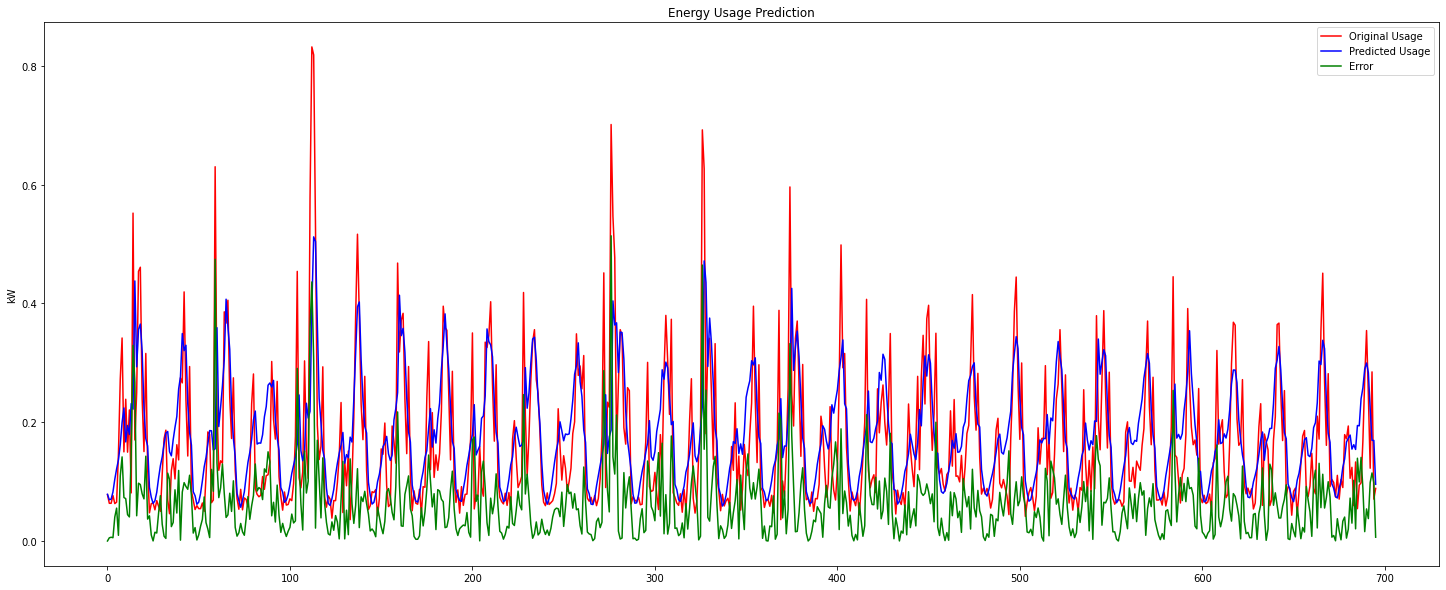

Mean Absolute Percentage Error:  0.48588927249862846
Mean Absolute Error:  0.0625906876922201
Max Absolute Error:  0.5138051906824113
Mean Squared Error:  0.007592729777112207
Testing with  MAC002026.csv


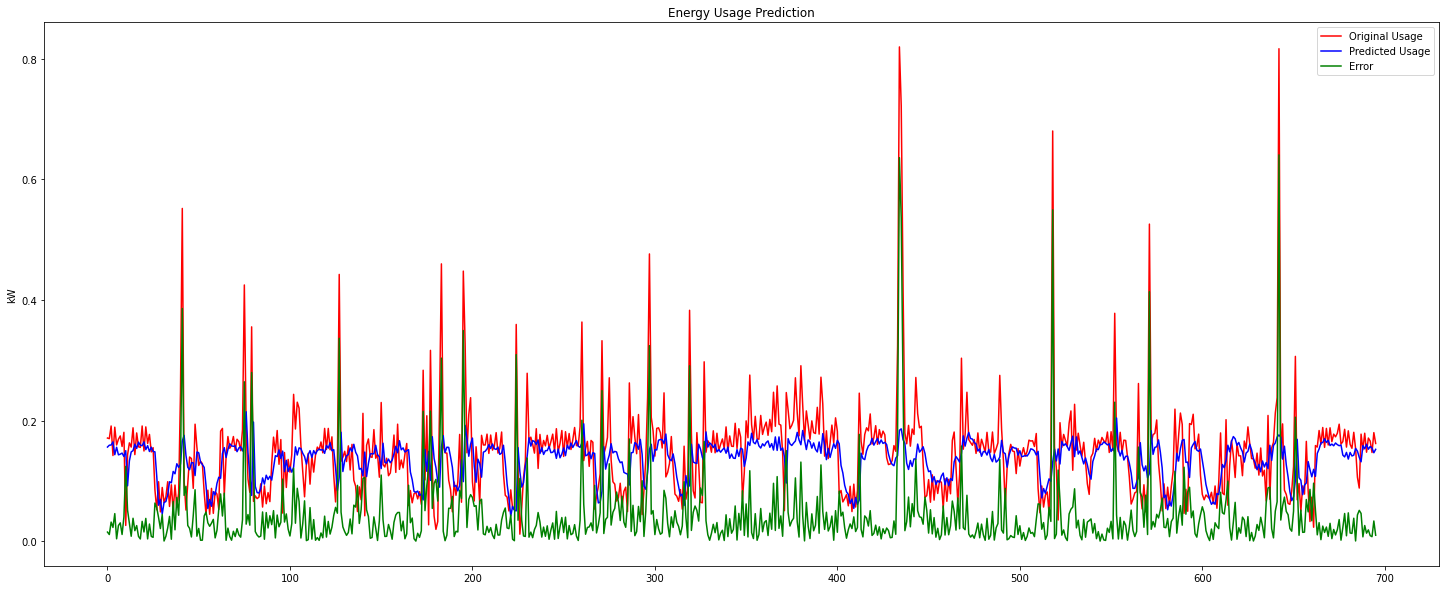

Mean Absolute Percentage Error:  0.3615911518736673
Mean Absolute Error:  0.043932163420593605
Max Absolute Error:  0.6408238394260407
Mean Squared Error:  0.006219613871897119
Testing with  MAC001029.csv


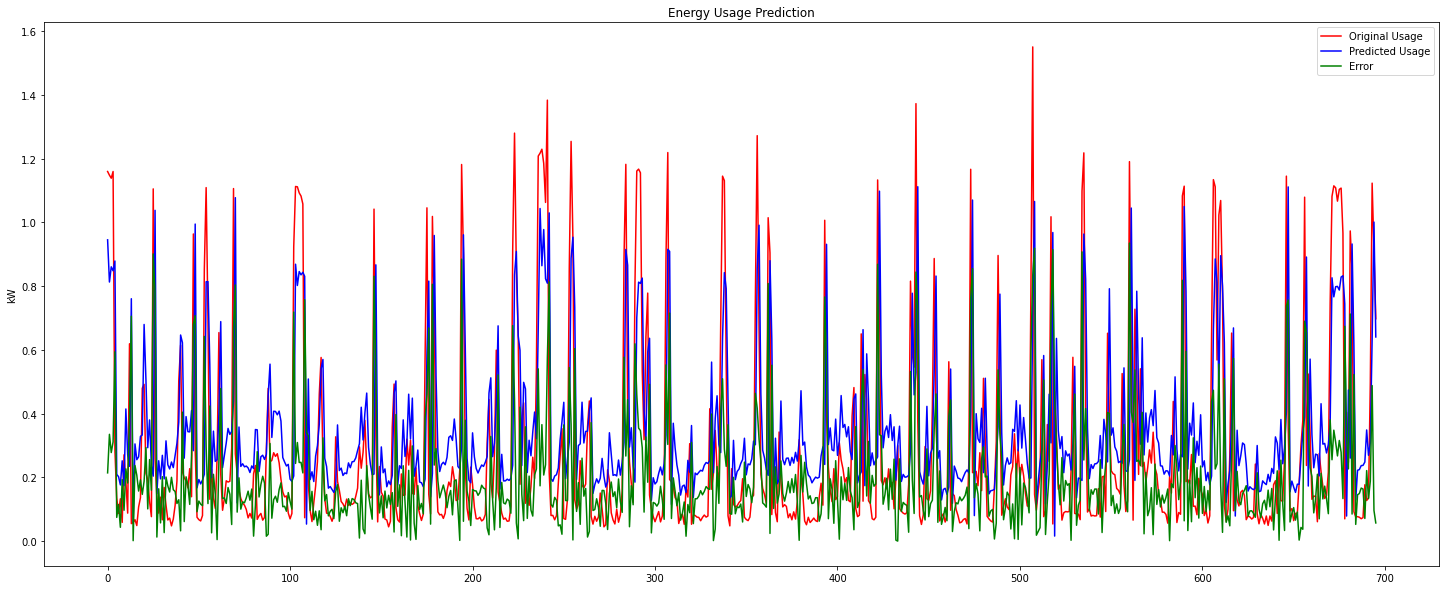

Mean Absolute Percentage Error:  1.3009745903434402
Mean Absolute Error:  0.20541101988779198
Max Absolute Error:  0.9354354987823486
Mean Squared Error:  0.07541492841096109
Testing with  MAC000201.csv


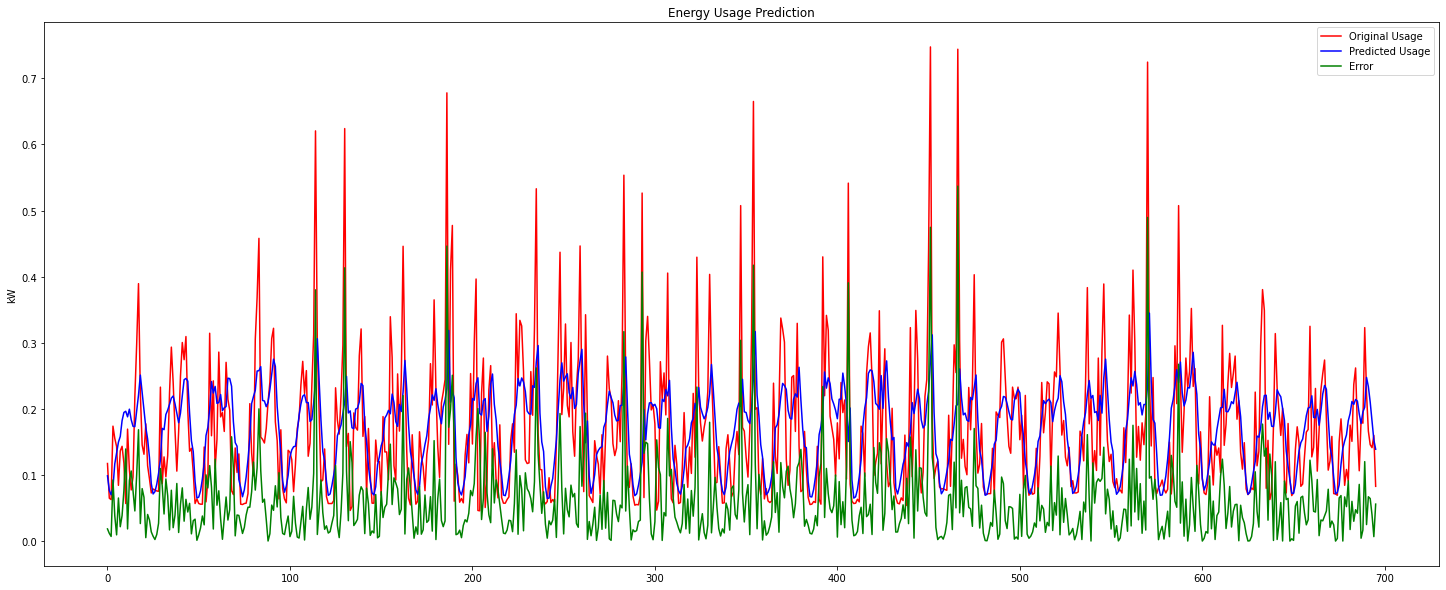

Mean Absolute Percentage Error:  0.4332279270315722
Mean Absolute Error:  0.061428723418250175
Max Absolute Error:  0.5369824739694596
Mean Squared Error:  0.007999208894714293
Testing with  MAC002172.csv


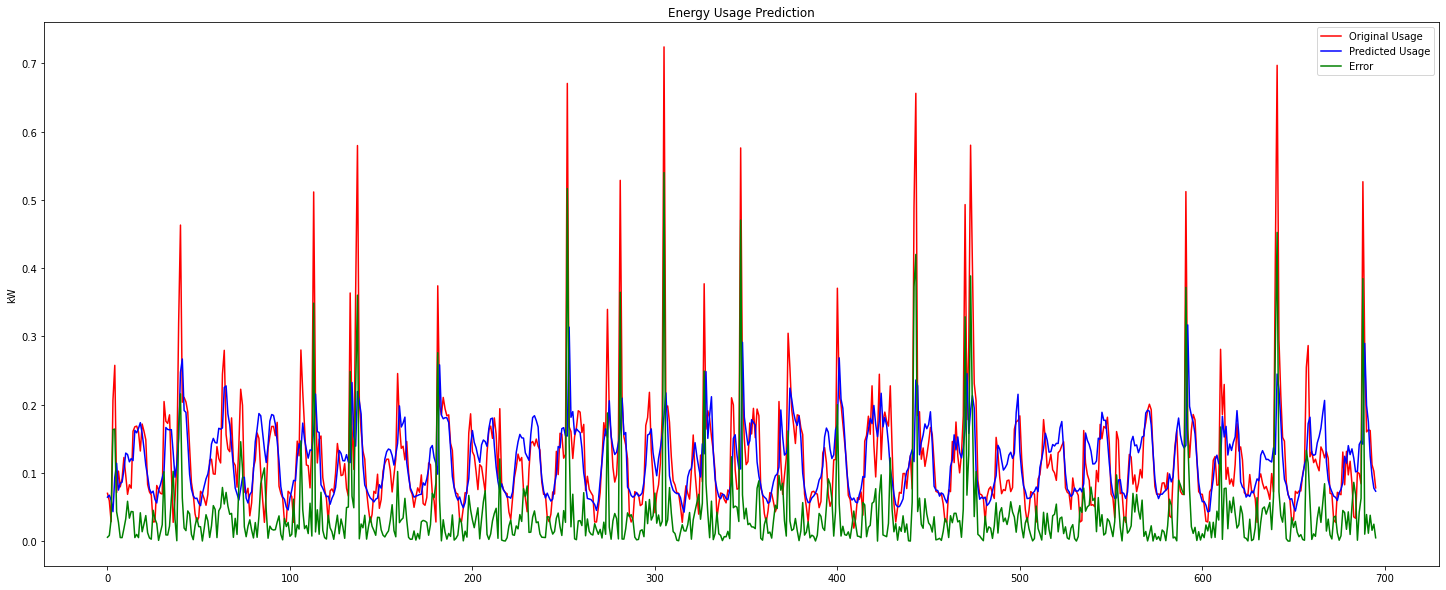

Mean Absolute Percentage Error:  0.3744241112191121
Mean Absolute Error:  0.04025295886894067
Max Absolute Error:  0.5398686161041261
Mean Squared Error:  0.005605256490529032
Testing with  MAC000054.csv


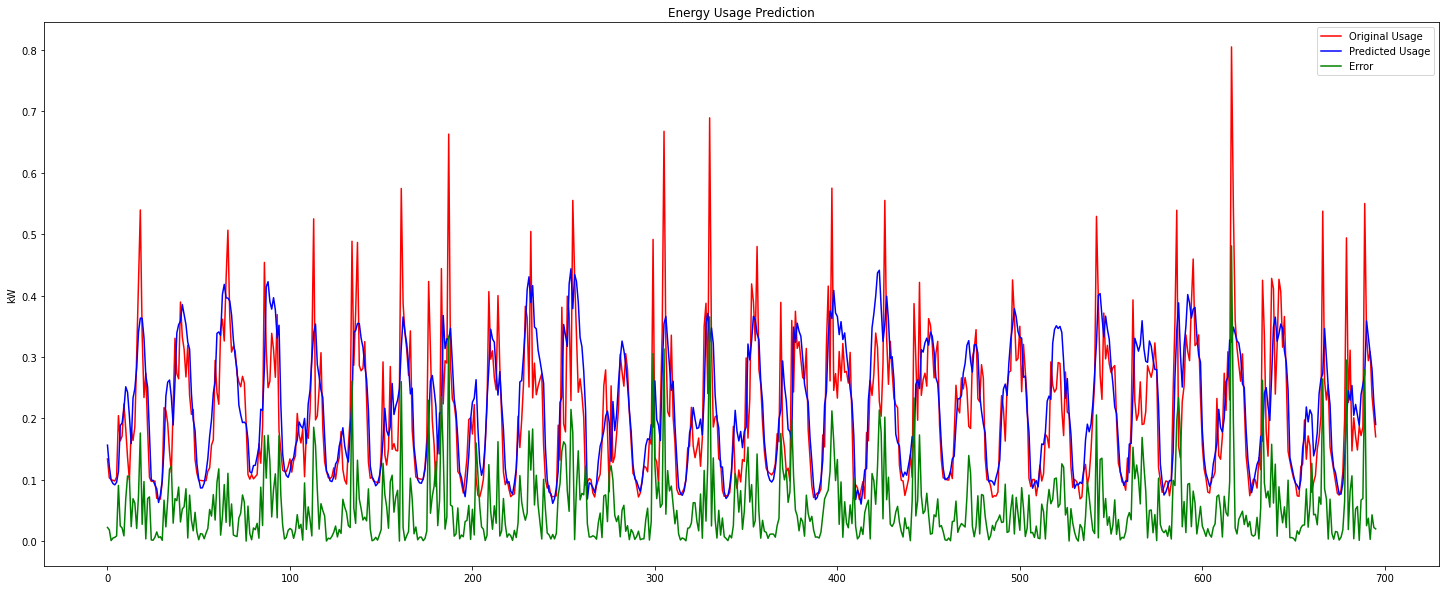

Mean Absolute Percentage Error:  0.26701380269436104
Mean Absolute Error:  0.05353177434598203
Max Absolute Error:  0.4809980916976928
Mean Squared Error:  0.0061477299754361765
Testing with  MAC001668.csv


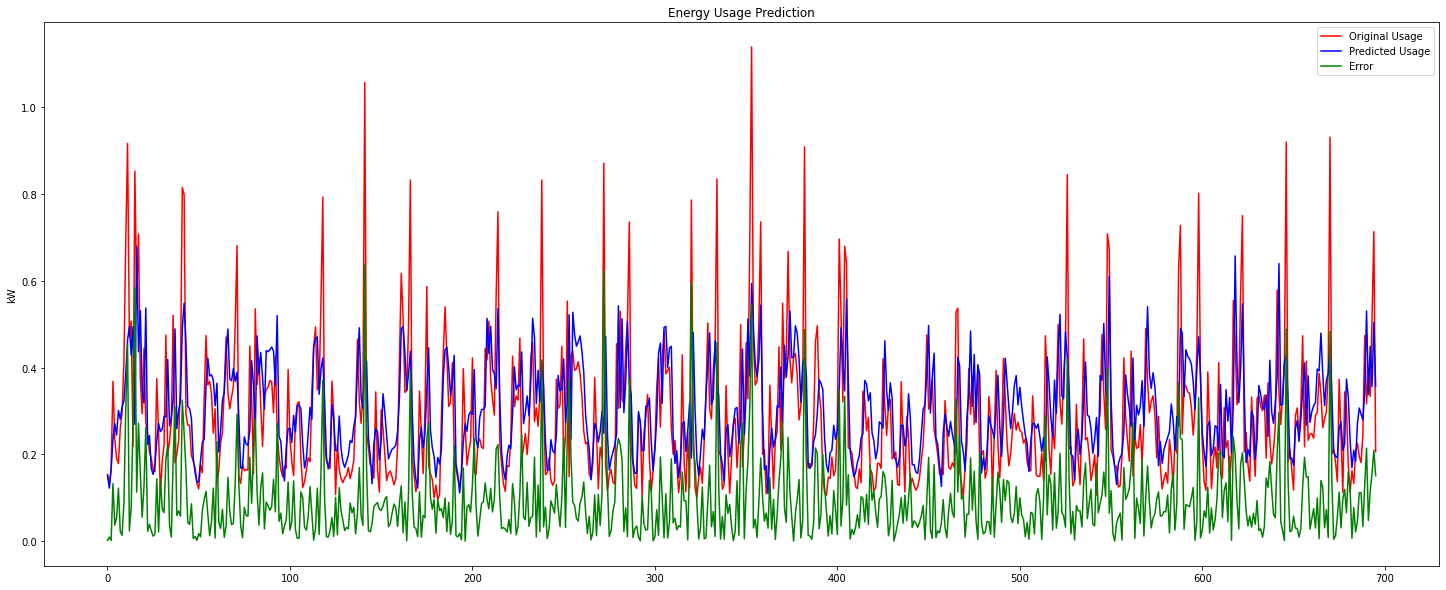

Mean Absolute Percentage Error:  0.3619050684590302
Mean Absolute Error:  0.0940003854703577
Max Absolute Error:  0.6368351233005525
Mean Squared Error:  0.01754570115759039
Testing with  MAC001971.csv


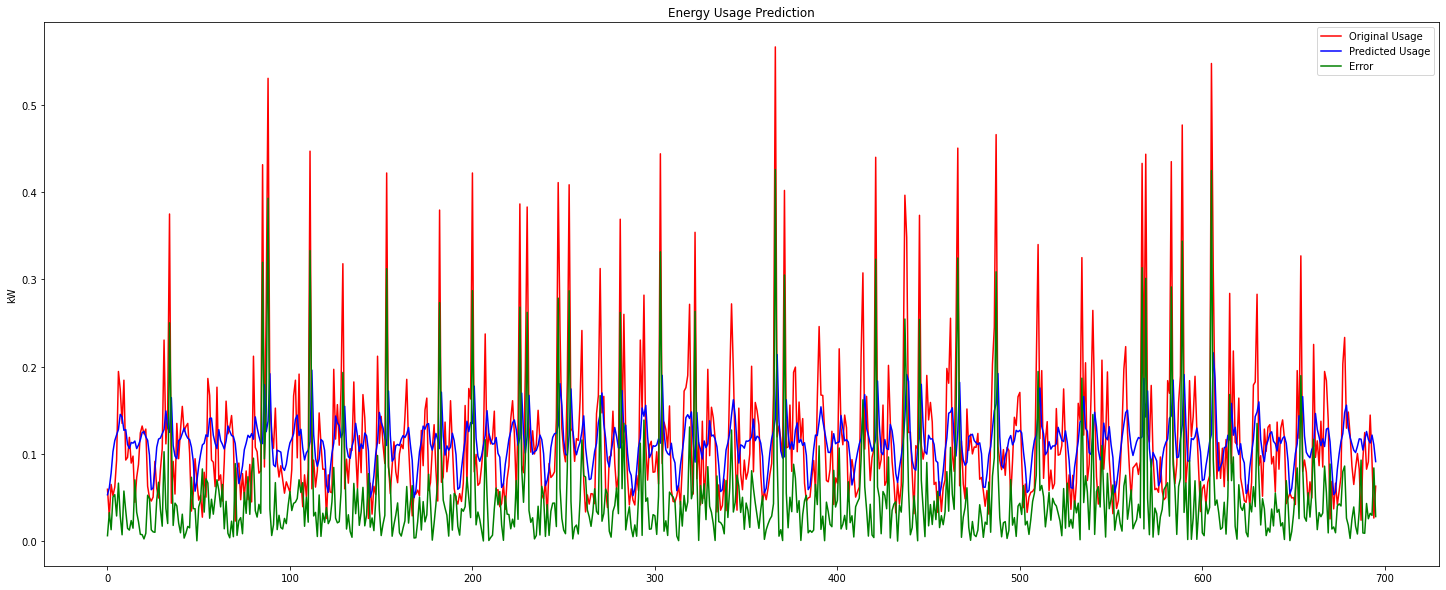

Mean Absolute Percentage Error:  0.5027406817137755
Mean Absolute Error:  0.05004247655179994
Max Absolute Error:  0.4260637083053589
Mean Squared Error:  0.006131122541524952
Testing with  MAC002150.csv


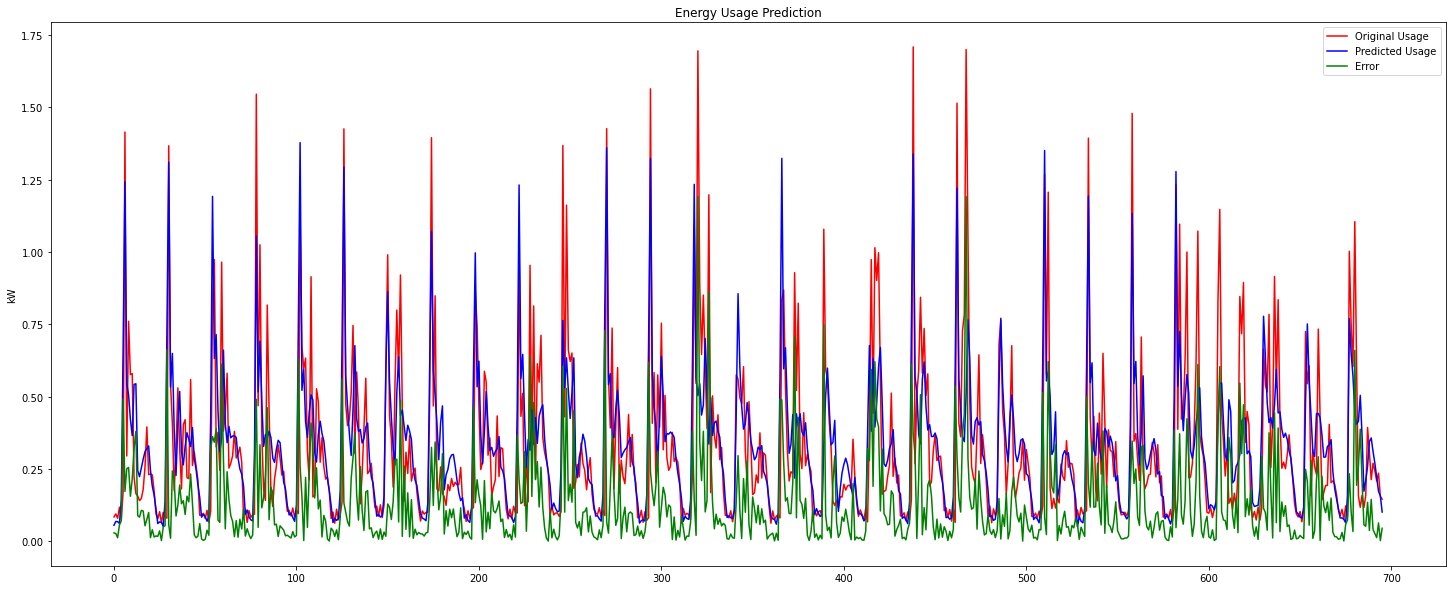

Mean Absolute Percentage Error:  0.5235649938003591
Mean Absolute Error:  0.12827576675376165
Max Absolute Error:  1.1928107842720033
Mean Squared Error:  0.040369290186434245
Testing with  MAC000166.csv


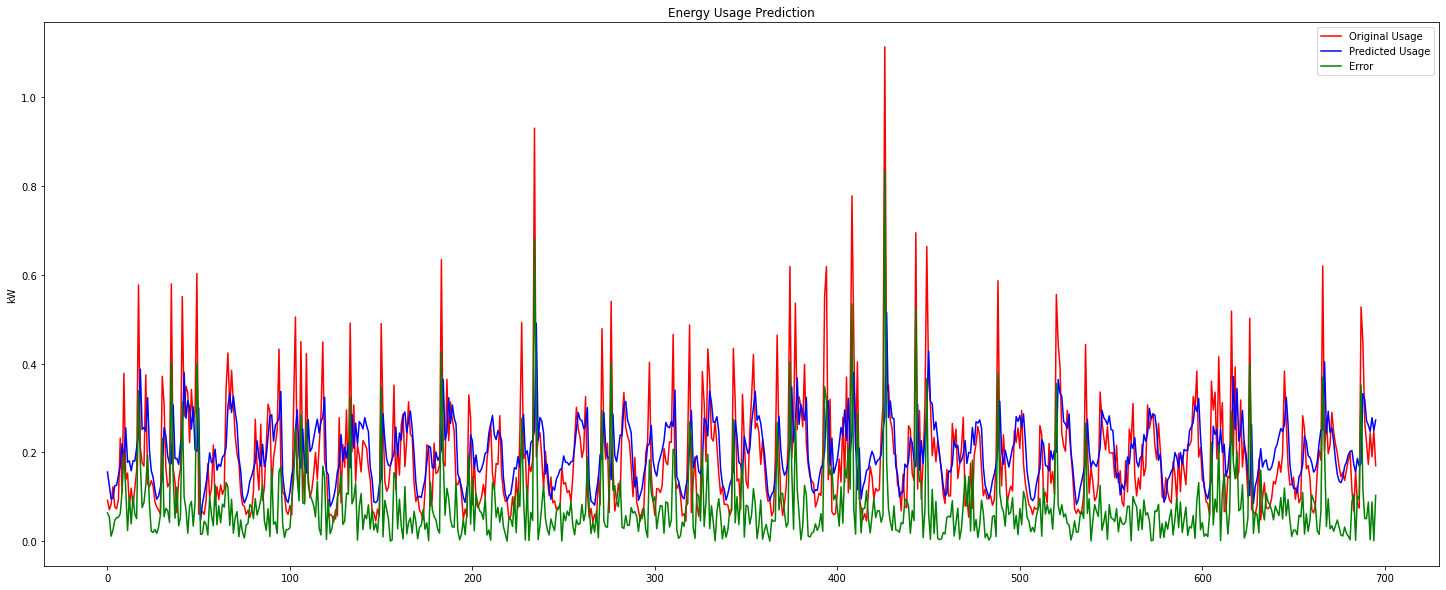

Mean Absolute Percentage Error:  0.5201052296852203
Mean Absolute Error:  0.0784079820477448
Max Absolute Error:  0.8324046974182129
Mean Squared Error:  0.013137088889238022


In [15]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')

    specific_model = define_model(past_window, len(featuresNames))
        
    features = df[featuresNames].values
    target = df[targetName].values.reshape(-1, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=24*30, shuffle=False)


    #SCALE
    x_scaler = MinMaxScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
    

    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train)

    #Time series
    batch_size=64
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)
    
    train(specific_model, train_generator)


    prediction = specific_model.predict(test_generator).reshape(-1, 1)
    prediction = y_scaler.inverse_transform(prediction)
    predict_evaluate(prediction, y_test[past_window:], showplots=True)

## loop, takes too much time with smv

In [ ]:
x_trainALL = []
y_trainALL = []
for filename in trainUsers:
    print("Training with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        #print(df.isna().values.any())
        #print(df[df['use'].isna()])
        #continue
        
        features = df[featuresNames].values
        target = df[targetName].values.reshape(-1,1)
        
        #SCALE
        x_scaler = StandardScaler()
        x_train = x_scaler.fit_transform(features)

        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(target)
        
        #Time series
        batch_size=1
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        svr_x_Train = [arr[0].flatten() for arr in train_generator]
        svr_y_Train = [arr[1].flatten() for arr in train_generator]
        
        x_trainALL += svr_x_Train
        y_trainALL += svr_y_Train
        

model.fit(x_trainALL, y_trainALL)
                
#prediction = model.predict(x_test).reshape(-1, 1)
#prediction = y_scaler.inverse_transform(prediction)

Training with  MAC000289.csv
Training with  MAC002565.csv
Training with  MAC002540.csv
Training with  MAC000720.csv
Training with  MAC002335.csv
Training with  MAC002285.csv
Training with  MAC000116.csv
Training with  MAC003289.csv
Training with  MAC000800.csv
Training with  MAC001445.csv
